## Overview

This notebook trains an autoencoder on the roboflow universe [iris detection database](https://universe.roboflow.com/eyedetection/iris-detection). 

The data has been pre-processed by `ExtractRoboflowDatasets.ipynb`, see that notebook for details.

The idea is that the features could be re-used on a small dataset to potentially improve performance.  (experiments needed)

## Python imports

In [1]:
import torch
from torch import nn
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torchvision import transforms
import torchvision.transforms as T
from torchvision.io import read_image
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchsummary import summary
import torch.nn.functional as F
from torchmetrics.classification import BinaryAccuracy
from sklearn.model_selection import StratifiedShuffleSplit
import torchvision
import wandb
import numpy as np

## Initialization

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
wandb.login()

Using device: cuda


wandb: Currently logged in as: tleyden (eyepi). Use `wandb login --relogin` to force relogin


True

## Constants

In [3]:
batch_size = 64
square_image_size = 128
data_root = "autoencoder_training_files"

## Define custom dataset and data loader

In [4]:
class RoboflowIrisDataset(Dataset):
    def __init__(self, annotations_file_or_df, img_dir, transform=None):
        
        if isinstance(annotations_file_or_df, str):
            self.img_labels = pd.read_csv(annotations_file_or_df)
        elif isinstance(annotations_file_or_df, pd.DataFrame):
            self.img_labels = annotations_file_or_df
        else:
            raise Exception(f"Unexpected object type for annotations_file_or_df: {self.img_labels}")
            
        self.img_dir = img_dir
        self.transform = transform

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx, 0]  # label is the image name - not very useful

        if self.transform:
            image = self.transform(image)
            image = image.to(self.device)
        return image, label, img_path

## Create data loader instances

In [5]:
transform = transforms.Compose([
    T.Resize((square_image_size,square_image_size)),
    T.ToTensor()
])

In [6]:
full_dataset = RoboflowIrisDataset(
    annotations_file_or_df=os.path.join(data_root, "annotations.csv"), 
    img_dir=data_root,
    transform=transform
)
data_loader_full = DataLoader(
    dataset=full_dataset,
    batch_size=batch_size,
    shuffle=True
)

## Define autoencoder CNN model

Results from [this training run](https://wandb.ai/eyepi/YouthEyeHealth/runs/zu03fpkk?workspace=user-tleyden)

![Screen Shot 2023-01-17 at 4 24 41 PM](https://user-images.githubusercontent.com/296876/213046252-4ed79c7b-2cbf-400e-9152-7d3242ad89d7.png)

In [55]:
class Autoencoder(nn.Module):
    """
    CNN autoencoder
    """
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7, stride=2, padding=1)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=7, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
model = Autoencoder().to(device)
model_summary = summary(model, input_size=(3, square_image_size, square_image_size))
print(model_summary)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
              ReLU-2           [-1, 16, 64, 64]               0
            Conv2d-3           [-1, 32, 32, 32]           4,640
              ReLU-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 14, 14]         100,416
   ConvTranspose2d-6           [-1, 32, 32, 32]         100,384
              ReLU-7           [-1, 32, 32, 32]               0
   ConvTranspose2d-8           [-1, 16, 64, 64]           4,624
              ReLU-9           [-1, 16, 64, 64]               0
  ConvTranspose2d-10          [-1, 3, 128, 128]             435
          Sigmoid-11          [-1, 3, 128, 128]               0
Total params: 210,947
Trainable params: 210,947
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/

## Define optimizer and loss function

In [56]:
# Compare L1 loss - torch.L1Loss() (abs value)
# criterion = nn.MSELoss()
criterion = nn.L1Loss()

learning_rate_autoencoder = 1e-3
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate_autoencoder, 
                             weight_decay=1e-5)

## Training loop

In [59]:
num_epochs = 50

data_loader = data_loader_full

wandb_config = {
  "learning_rate": learning_rate_autoencoder,
  "architecture": "CNNAutoencoder",
  "dataset": "RoboflowIrisDataset",
  "dataset_size": len(full_dataset),
  "loss_fn": criterion,
  "epochs": num_epochs,
  "model_summary": model_summary
}

wandb.init(
  # Use team
  entity="eyepi",
  # Set the project where this run will be logged
  project="YouthEyeHealth", 
  # Track hyperparameters and run metadata
  config=wandb_config
)

outputs = []
for epoch in range(num_epochs):
    for (img, _, _) in tqdm(data_loader):

        # put on gpu if avail
        img = img.to(device)
                
        recon = model(img).to(device)
        
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    wandb.log({"epoch": epoch+1, "loss": loss.item()})
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    print(f"appending to outputs: img with shape {img.shape} and reconstructed image with shape {recon.shape}")
    outputs.append((epoch, img, recon))
    
wandb.finish()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.49it/s]


Epoch:1, Loss:0.0211
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.60it/s]


Epoch:2, Loss:0.0244
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.74it/s]


Epoch:3, Loss:0.0220
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.73it/s]


Epoch:4, Loss:0.0206
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.38it/s]


Epoch:5, Loss:0.0201
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.75it/s]


Epoch:6, Loss:0.0191
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.54it/s]


Epoch:7, Loss:0.0190
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.58it/s]


Epoch:8, Loss:0.0193
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.02it/s]


Epoch:9, Loss:0.0180
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.56it/s]


Epoch:10, Loss:0.0158
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.76it/s]


Epoch:11, Loss:0.0173
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.33it/s]


Epoch:12, Loss:0.0166
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.36it/s]


Epoch:13, Loss:0.0174
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.55it/s]


Epoch:14, Loss:0.0162
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.71it/s]


Epoch:15, Loss:0.0154
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.13it/s]


Epoch:16, Loss:0.0168
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.69it/s]


Epoch:17, Loss:0.0189
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.68it/s]


Epoch:18, Loss:0.0168
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.80it/s]


Epoch:19, Loss:0.0157
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.56it/s]


Epoch:20, Loss:0.0129
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.42it/s]


Epoch:21, Loss:0.0159
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.51it/s]


Epoch:22, Loss:0.0162
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.51it/s]


Epoch:23, Loss:0.0148
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.63it/s]


Epoch:24, Loss:0.0159
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.76it/s]


Epoch:25, Loss:0.0147
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.78it/s]


Epoch:26, Loss:0.0158
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.24it/s]


Epoch:27, Loss:0.0165
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.16it/s]


Epoch:28, Loss:0.0150
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:06<00:00, 12.76it/s]


Epoch:29, Loss:0.0137
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:06<00:00, 12.51it/s]


Epoch:30, Loss:0.0124
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.46it/s]


Epoch:31, Loss:0.0142
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.75it/s]


Epoch:32, Loss:0.0138
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.30it/s]


Epoch:33, Loss:0.0139
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.11it/s]


Epoch:34, Loss:0.0138
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.31it/s]


Epoch:35, Loss:0.0122
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.19it/s]


Epoch:36, Loss:0.0146
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.53it/s]


Epoch:37, Loss:0.0141
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.21it/s]


Epoch:38, Loss:0.0140
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.42it/s]


Epoch:39, Loss:0.0124
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.71it/s]


Epoch:40, Loss:0.0149
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:06<00:00, 13.73it/s]


Epoch:41, Loss:0.0150
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.13it/s]


Epoch:42, Loss:0.0140
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.47it/s]


Epoch:43, Loss:0.0142
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.16it/s]


Epoch:44, Loss:0.0130
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.42it/s]


Epoch:45, Loss:0.0124
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.04it/s]


Epoch:46, Loss:0.0138
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.01it/s]


Epoch:47, Loss:0.0121
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.54it/s]


Epoch:48, Loss:0.0136
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.38it/s]


Epoch:49, Loss:0.0143
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.15it/s]

Epoch:50, Loss:0.0119
appending to outputs: img with shape torch.Size([23, 3, 128, 128]) and reconstructed image with shape torch.Size([23, 3, 128, 128])


## Visualize autoencoder results

/tmp/ipykernel_2324155/2270200968.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(9, 2))


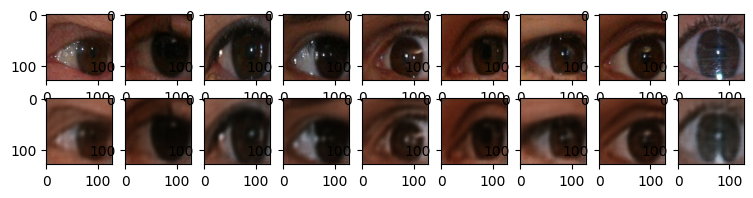

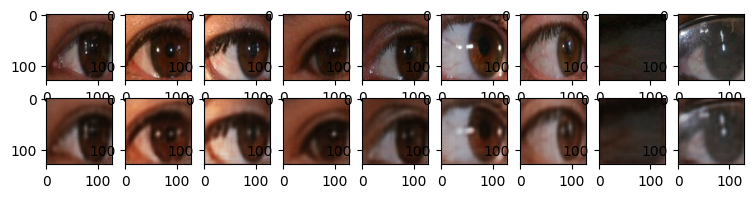

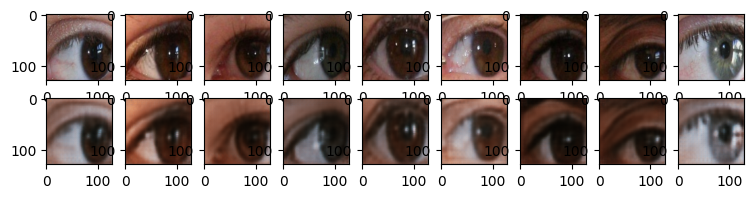

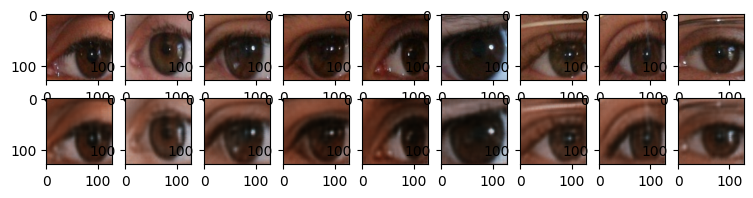

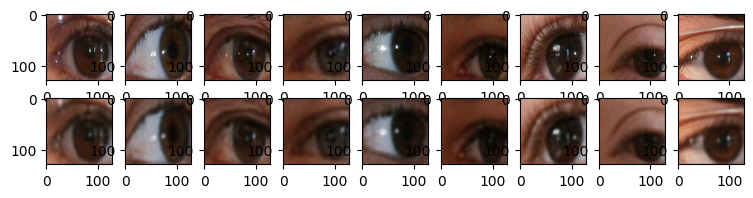

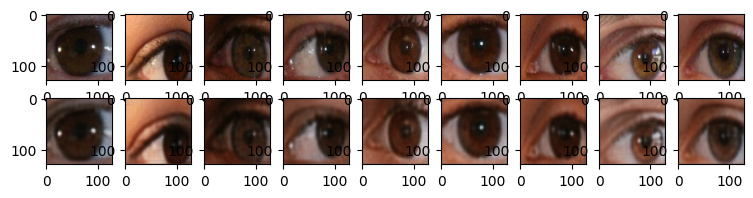

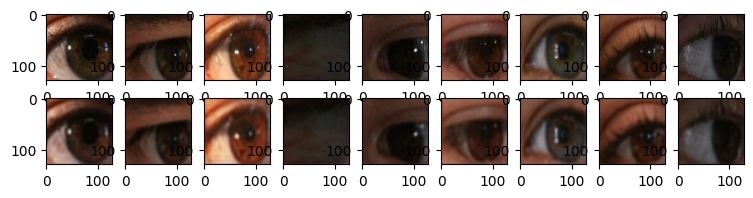

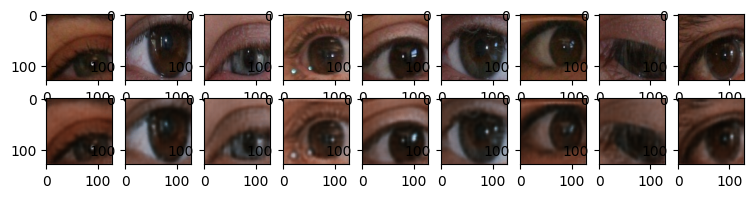

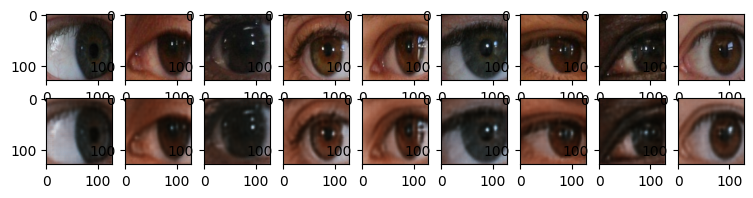

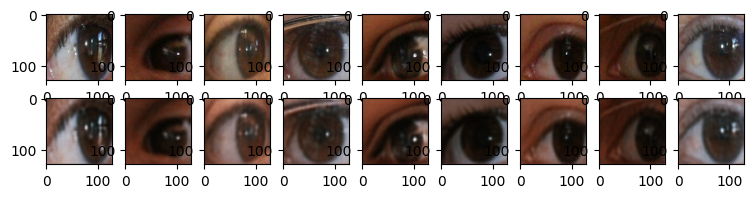

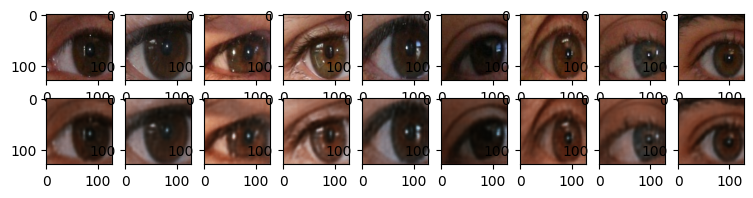

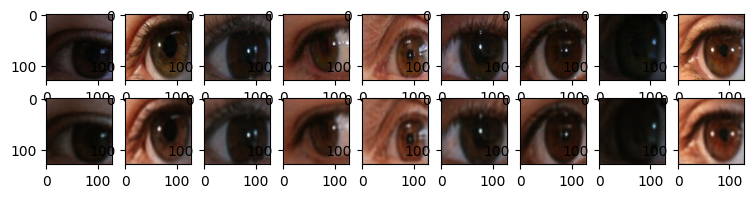

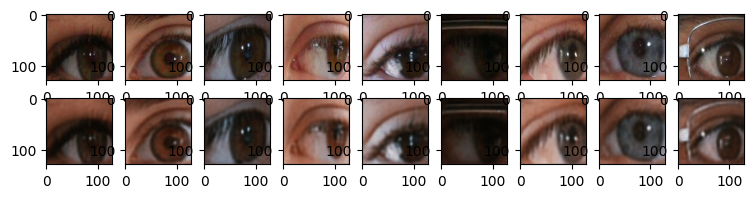

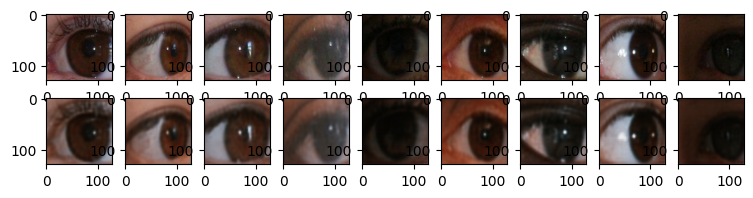

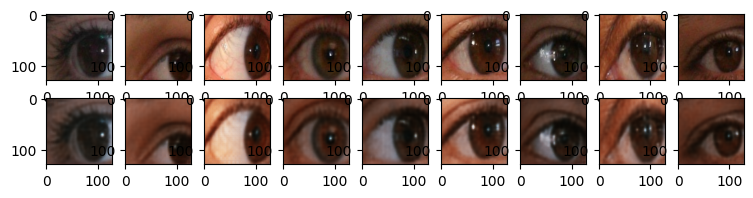

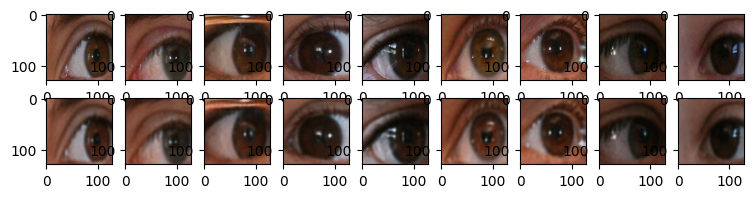

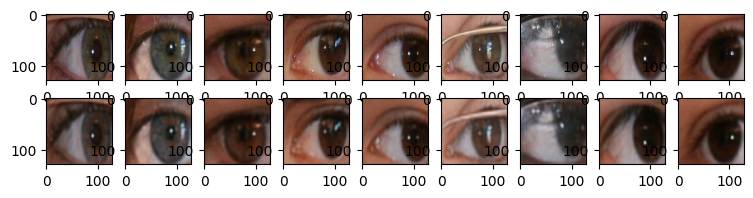

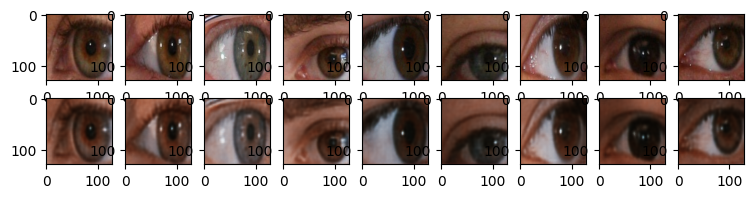

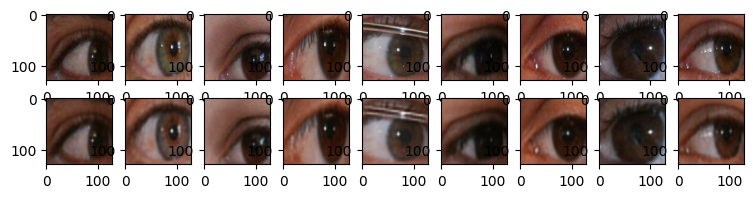

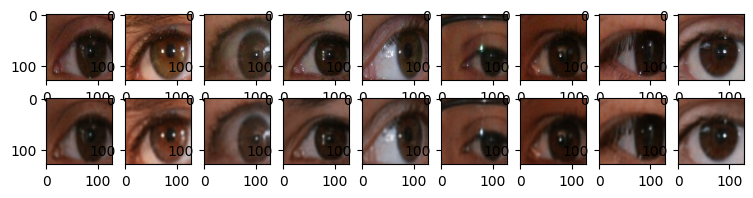

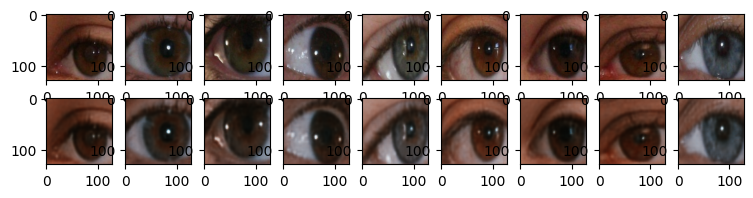

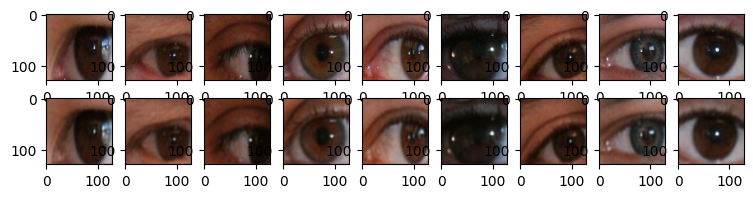

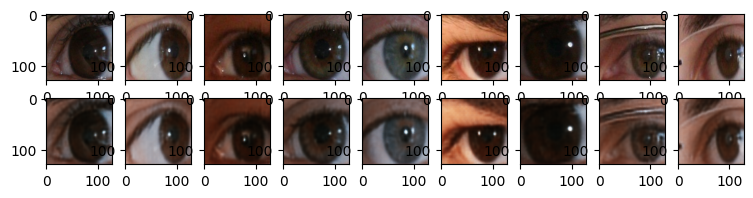

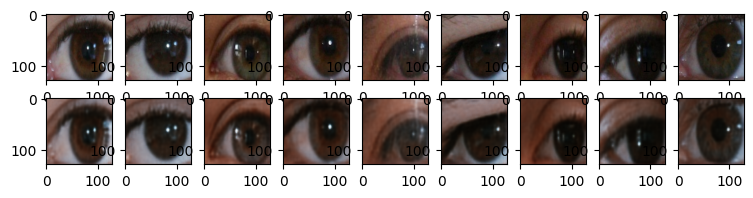

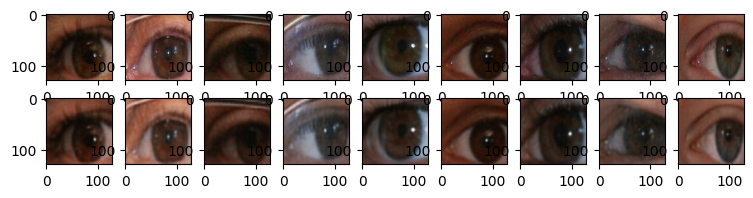

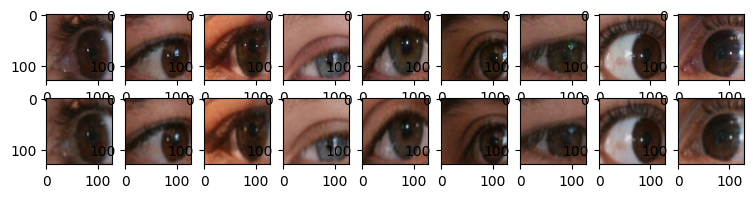

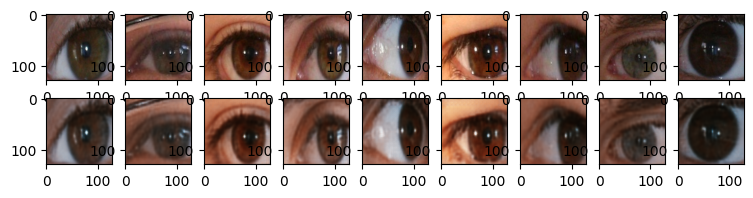

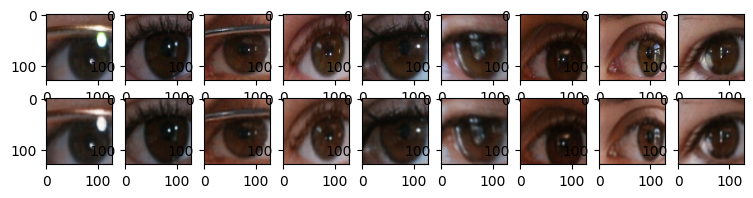

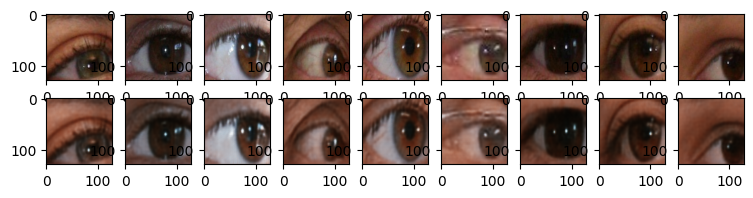

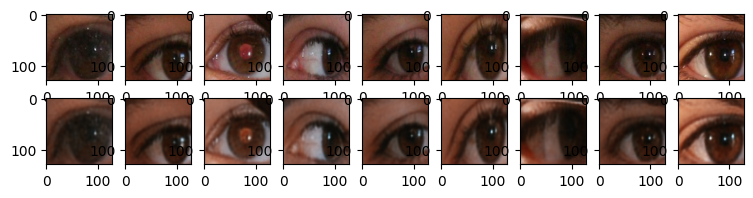

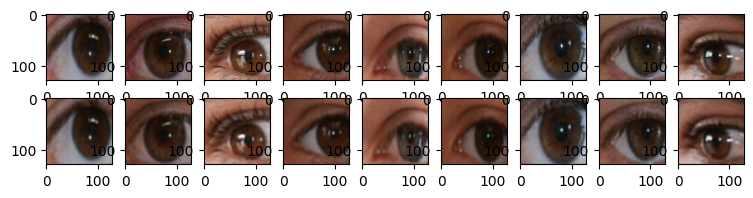

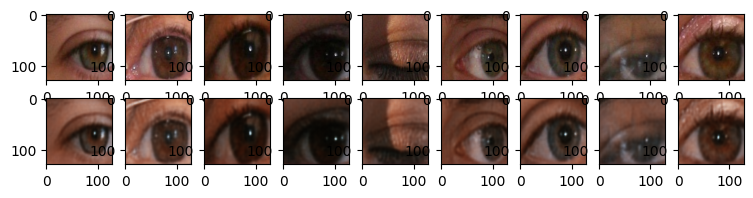

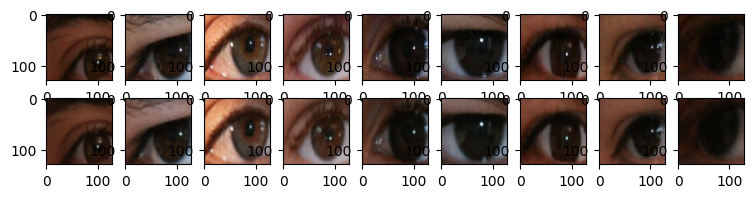

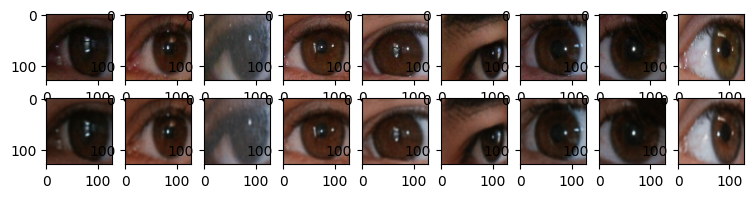

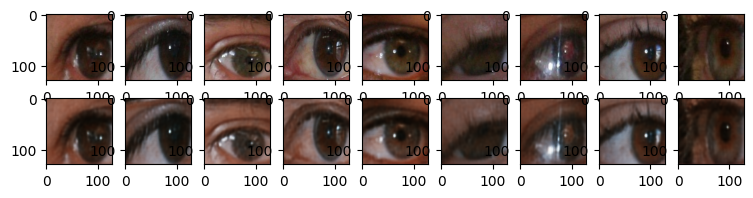

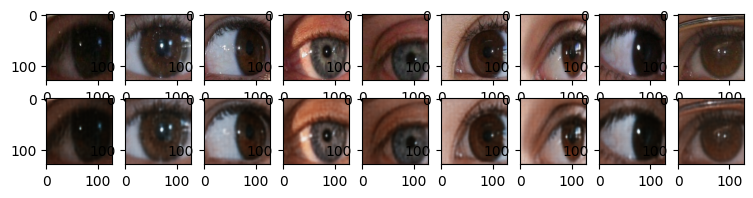

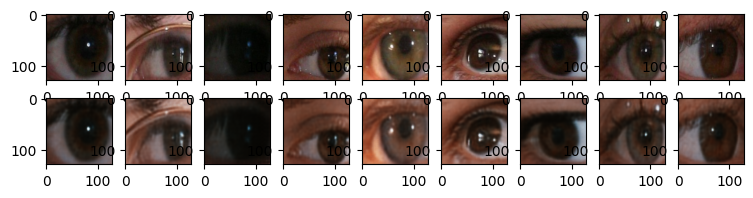

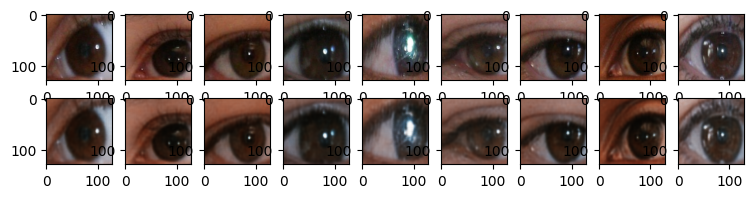

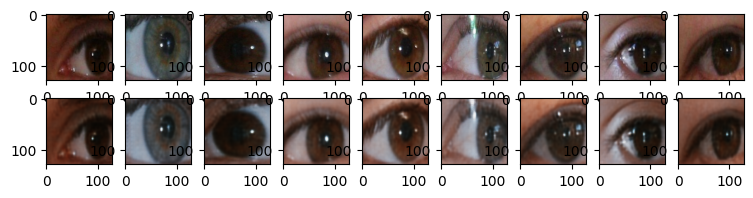

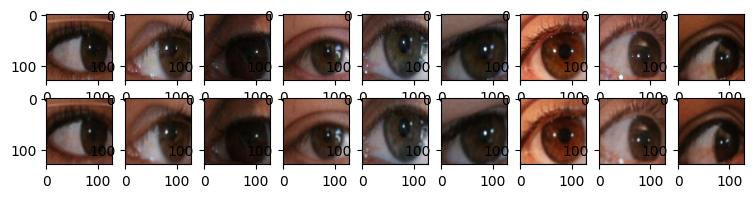

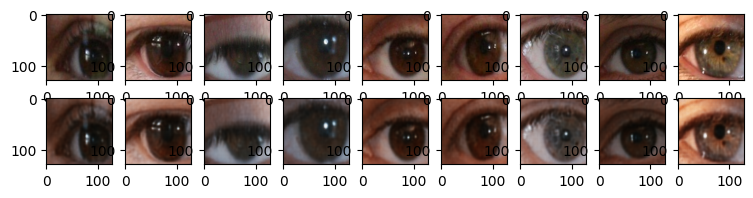

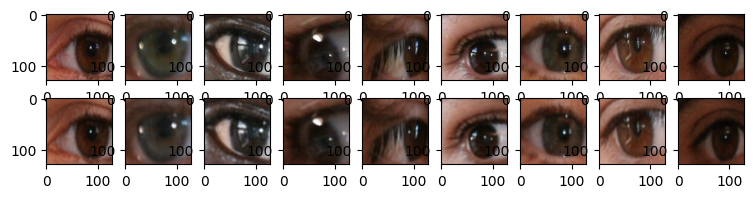

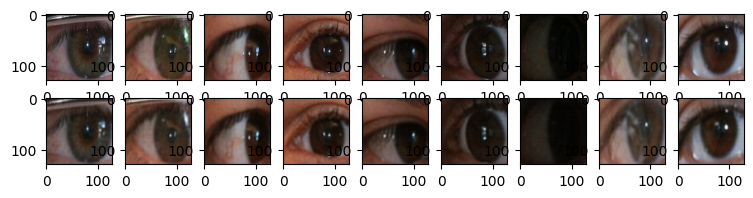

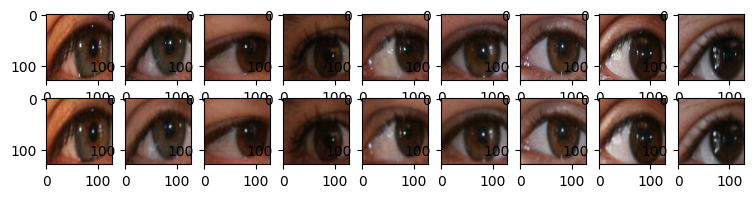

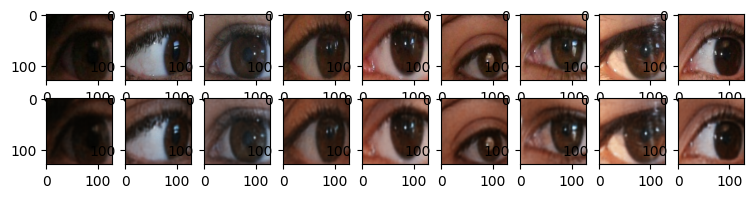

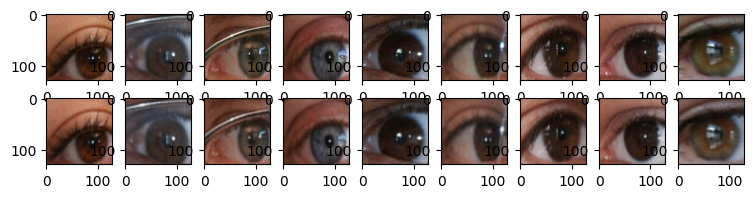

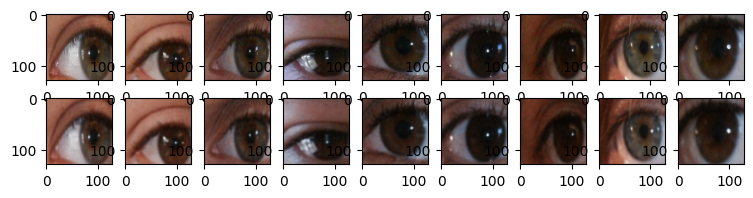

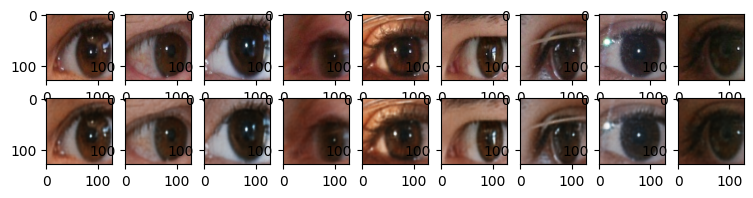

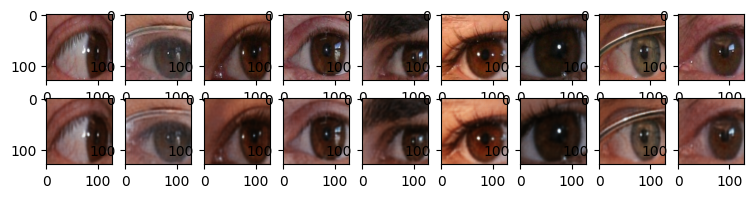

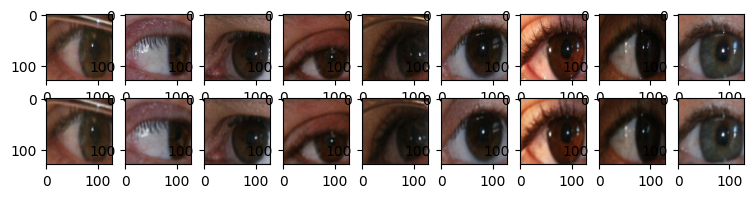

In [60]:
for k in range(0, len(outputs)):
    plt.figure(figsize=(9, 2))
    imgs = outputs[k][1].cpu().detach().numpy()
    recon = outputs[k][2].cpu().detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, square_image_size, square_image_size)
        # Matplot lib expects the image to be in (H, W, C) format, where C = channels 
        img = np.transpose(item, (1, 2, 0))
        plt.imshow(img)

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        item = item.reshape(-1, square_image_size, square_image_size)
        img = np.transpose(item, (1, 2, 0))
        plt.imshow(img)

In [43]:
imgs = outputs[0][1].cpu().detach().numpy()
recon = outputs[0][2].cpu().detach().numpy()

In [44]:
len(imgs)

23

In [45]:
img0 = imgs[0]
recon0 = recon[0]

In [48]:
delta = img0 - recon0

In [54]:
np.sum(delta)

126.422966